In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from math import exp, sqrt,pi
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

In [2]:
epochs = 100
device = torch.device("cpu")

eps = 0.1

learning_rate = 1e-3
batchflag = True
batchsize = 128

start = 0.
end = 1.
x = np.linspace(start,end,100 )
y = np.linspace(start,end,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))

def actual_soln(eps):
    sinpix = np.array([[math.sin(math.pi*ind[0])] for ind in x])
    sinpiy = np.array([[math.sin(math.pi*ind[0])] for ind in y])
    return ((sinpix)**2) * ((sinpiy)**2)
#f = 8*(eps**2)*((math.pi)**4)*(cos2pix*cos2piy - cos2pix*sinpiy*sinpiy - cos2piy*sinpix*sinpix) - 2*((math.pi)**2)*(cos2pix*sinpiy*sinpiy + cos2piy*sinpix*sinpix)

In [10]:
def plot_graph(soln,soln_name):
    x = np.linspace(start,end,100);y = np.linspace(start,end,100)
    x,y = np.meshgrid(x,y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x,y,soln.reshape(100,100))
    plt.title(soln_name)
    plt.show()

class Swish(nn.Module):
	def __init__(self, inplace=True):
		super(Swish, self).__init__()
		self.inplace = inplace

	def forward(self, x):
		if self.inplace:
			x.mul_(torch.sigmoid(x))
			return x
		else:
			return x * torch.sigmoid(x)
	

class FBPINN(nn.Module):
	hid_dim = 128
	input_dim = 2 
	def __init__(self):
		super(FBPINN, self).__init__()
		self.tanh = nn.Tanh()
		self.lin0 = nn.Linear(self.input_dim,self.hid_dim)
		self.lin = nn.Linear(self.hid_dim,self.hid_dim)
		self.lin1 = nn.Linear(self.hid_dim,1)
		self.swish = Swish()


	def forward(self,x):		
		tanh1 = self.tanh(x)
		tanh2 = self.tanh(1 - x)
		tanh11 = (tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))*(tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))
		tanh22 = (tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))*(tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))
		x = self.lin0(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin1(x)
		out = x*tanh11*tanh22
		return  out

def lag_coeffs(num):
		lis = [np.array([1]),np.array([1,-1])]
		for n in range(1,num-1):
			xl1 = np.concatenate((np.array([0]),lis[n]),axis = 0)
			l1 = np.concatenate((lis[n],np.array([0])),axis = 0)		
			l0 = np.concatenate((lis[n-1],np.array([0,0])),axis = 0)
			l = ((2*n + 1)*l1 - xl1 - n*l0)/(n + 1)
			lis.append(l)
		for n in range(num):
			lis[n] = np.concatenate((lis[n],np.array([0]*(num-1-n))),axis = 0)
		return lis

def poly(coeffs,x):
	sum = torch.zeros_like(x)
	for i,coeff in enumerate(coeffs):
		sum = sum + coeff*(x**i)
	return sum

class Lag_FBPINN(nn.Module):
	def __init__(self,basis_num):
		super(Lag_FBPINN,self).__init__()
		self.tanh = nn.Tanh()
		self.basis_num = basis_num
		self.main = nn.Sequential(
			#nn.Linear(2*basis_num,2*basis_num),
			nn.Linear(2*basis_num,1))		
	def forward(self,input):
		tanh1 = self.tanh(input)
		tanh2 = self.tanh(1 - input)
		tanh11 = (tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))*(tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))
		tanh22 = (tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))*(tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))
		coeffs = lag_coeffs(self.basis_num)
		x = input[:,0]
		t = input[:,1]
		netin = torch.Tensor([])
		for i in range(self.basis_num):
			netin = torch.cat((netin,poly(coeffs[i],x.view(-1,1))),1)
		for i in range(self.basis_num):
			netin = torch.cat((netin,poly(coeffs[i],t.view(-1,1))),1)
		netout = self.main(netin)
		return netout*tanh11*tanh22

In [11]:

def train(device,x,y,eps,learning_rate,epochs,batch_flag,batch_size):

	xnet = torch.Tensor(x)
	ynet = torch.Tensor(y) 
	if(batch_flag):
		dataset = TensorDataset(xnet,ynet)
		dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers = 0,drop_last = True )
		print(len(dataloader))

	net = FBPINN()#.to(device)
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	net.apply(init_normal)

	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(xnet,ynet):
		xnet.requires_grad = True
		ynet.requires_grad = True
		points = torch.cat((xnet,ynet),1) 
		U = net(points)
		U = U.view(len(U),-1)
		
		soln = (torch.sin(np.pi*xnet))**2 * (torch.sin(np.pi*ynet))**2
		
		soln_x = torch.autograd.grad(soln,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xx = torch.autograd.grad(soln_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxx = torch.autograd.grad(soln_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxxx = torch.autograd.grad(soln_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_y = torch.autograd.grad(soln,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yy = torch.autograd.grad(soln_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyy = torch.autograd.grad(soln_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyyy = torch.autograd.grad(soln_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxy = torch.autograd.grad(soln_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxyy = torch.autograd.grad(soln_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		
		f = (eps**2)*(soln_xxxx + soln_yyyy + 2*soln_xxyy) - (soln_xx + soln_yy)
		
		U_x = torch.autograd.grad(U,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxx = torch.autograd.grad(U_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxxx = torch.autograd.grad(U_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyy = torch.autograd.grad(U_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyyy = torch.autograd.grad(U_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxy = torch.autograd.grad(U_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxyy = torch.autograd.grad(U_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		loss1 = (eps**2)*(U_xxxx + U_yyyy + 2*U_xxyy) - (U_xx + U_yy) - f 
		
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	losses = []
	tic = time.time()

	if(batch_flag):
		for epoch in range(epochs):
			if epoch == 30:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
			for batch_idx, (x_in,y_in) in enumerate(dataloader):

				net.zero_grad()
				loss = Loss_criterion(x_in,y_in)
				loss.backward()

				optimizer.step() 
				if batch_idx % 20 ==0:
					print('Train Epoch: {} \tLoss: {:.20f}'.format(epoch, loss.item()))

			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.20f}\n'.format(
				epoch, actual_loss))
			if epoch % 1 == 0:
				plot_graph(z,'Predicted solution')
			
			losses.append([loss.item(),actual_loss])

	else:
		for epoch in range(epochs):
			if epoch == 50:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
		
			net.zero_grad()
			loss = Loss_criterion(xnet,ynet)
			loss.backward()
			
			optimizer.step() 
			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.10f}\n'.format(
				epoch, actual_loss))
			if epoch % 5 == 0:
				plot_graph(z,'Predicted solution')
			
			losses.append([loss.item(),actual_loss])

	toc = time.time()
	elapseTime = toc - tic
	print ("Time elapsed = ", elapseTime)

	net_in = torch.cat((xnet,ynet),1)
	output = net(net_in)  
	
	return output,losses 

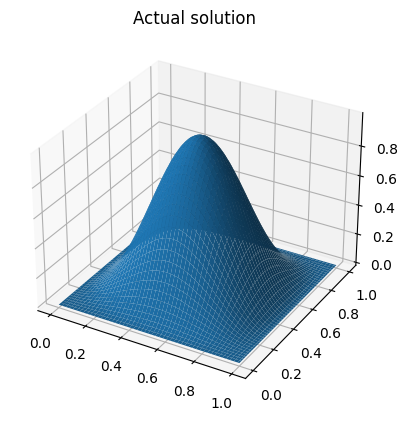

In [12]:
plot_graph(actual_soln(eps),'Actual solution')

78
Train Epoch: 0 	Loss: 517.1259155273
Train Epoch: 0 	Loss: 482.4604492188
Train Epoch: 0 	Loss: 319.4771728516
Train Epoch: 0 	Loss: 72.5265579224

After Epoch 0, 	 Actual solution loss: 0.0025362054



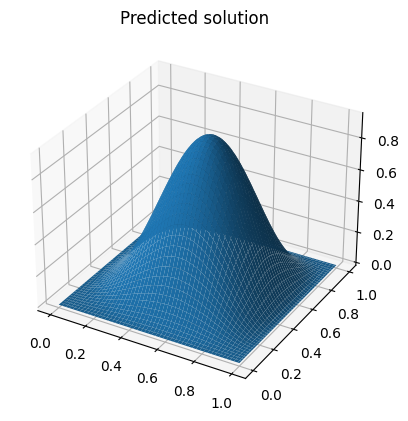

Train Epoch: 1 	Loss: 65.5268402100
Train Epoch: 1 	Loss: 43.8383789062
Train Epoch: 1 	Loss: 22.5601139069
Train Epoch: 1 	Loss: 15.2246751785

After Epoch 1, 	 Actual solution loss: 0.0005085742



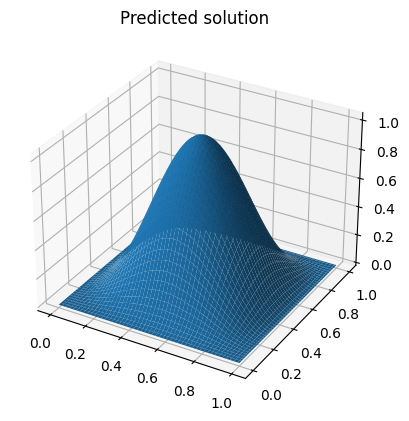

Train Epoch: 2 	Loss: 5.9035053253
Train Epoch: 2 	Loss: 2.0876820087
Train Epoch: 2 	Loss: 0.7399504185
Train Epoch: 2 	Loss: 0.5491609573

After Epoch 2, 	 Actual solution loss: 0.0000609606



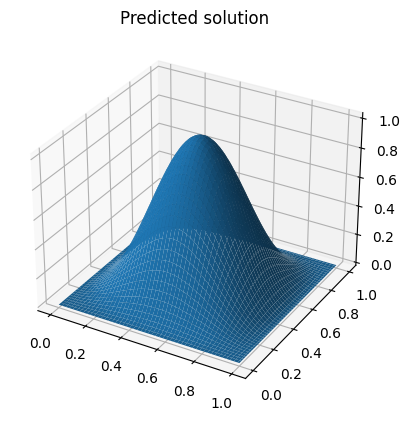

Train Epoch: 3 	Loss: 0.3087283075
Train Epoch: 3 	Loss: 0.1892138720
Train Epoch: 3 	Loss: 0.2118210942
Train Epoch: 3 	Loss: 0.1145601794

After Epoch 3, 	 Actual solution loss: 0.0000206582



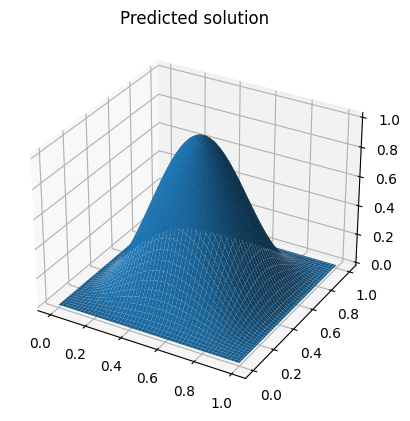

Train Epoch: 4 	Loss: 0.0735405684
Train Epoch: 4 	Loss: 0.0614112243
Train Epoch: 4 	Loss: 0.0533444062
Train Epoch: 4 	Loss: 0.0474915393

After Epoch 4, 	 Actual solution loss: 0.0000028249



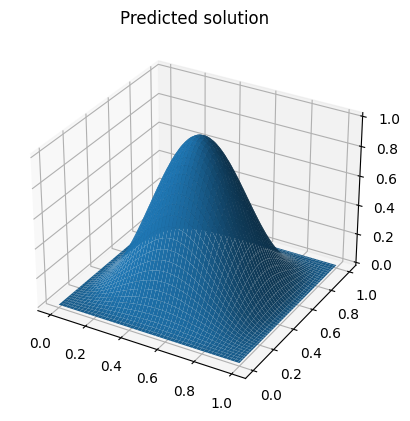

Train Epoch: 5 	Loss: 0.0317426473
Train Epoch: 5 	Loss: 0.0266081635
Train Epoch: 5 	Loss: 0.0186894890
Train Epoch: 5 	Loss: 0.0165232345

After Epoch 5, 	 Actual solution loss: 0.0000031121



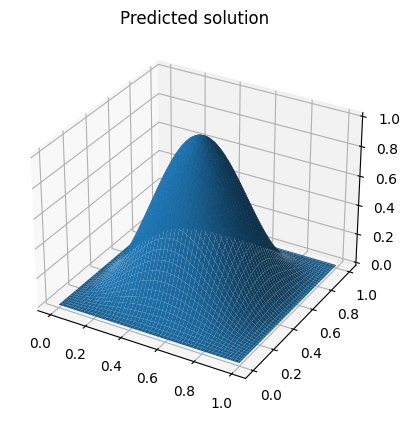

Train Epoch: 6 	Loss: 0.0164654553
Train Epoch: 6 	Loss: 0.0140786078
Train Epoch: 6 	Loss: 0.0122207226
Train Epoch: 6 	Loss: 0.0110725705

After Epoch 6, 	 Actual solution loss: 0.0000002046



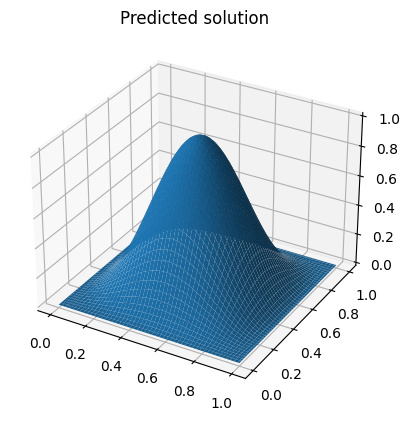

Train Epoch: 7 	Loss: 0.0098481765
Train Epoch: 7 	Loss: 0.0113400687
Train Epoch: 7 	Loss: 0.0090673566
Train Epoch: 7 	Loss: 0.0058479384

After Epoch 7, 	 Actual solution loss: 0.0000007738



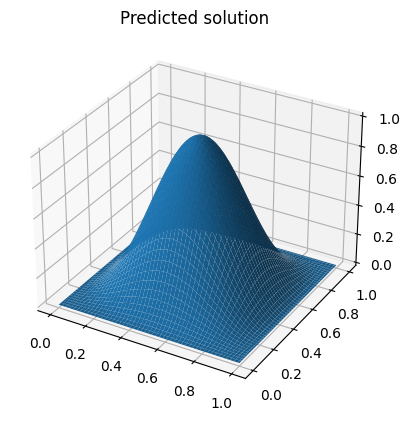

Train Epoch: 8 	Loss: 0.0050867805
Train Epoch: 8 	Loss: 0.0053603891
Train Epoch: 8 	Loss: 0.0047455677
Train Epoch: 8 	Loss: 0.0055283820

After Epoch 8, 	 Actual solution loss: 0.0000000616



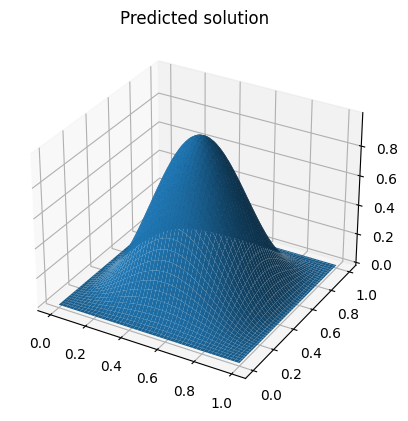

Train Epoch: 9 	Loss: 0.0041492875
Train Epoch: 9 	Loss: 0.0040599490
Train Epoch: 9 	Loss: 0.0082446979
Train Epoch: 9 	Loss: 0.0040119630

After Epoch 9, 	 Actual solution loss: 0.0000000443



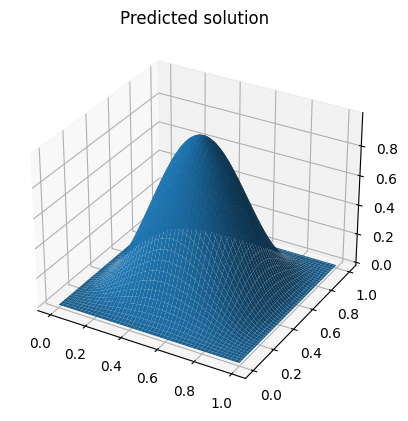

Time elapsed =  431.59560322761536


In [13]:
output,losses = train(device,x,y,eps,learning_rate,epochs,batchflag,batchsize)

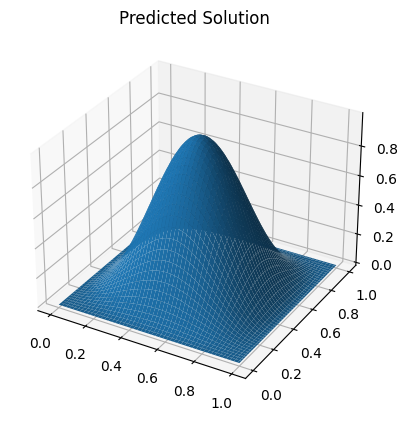

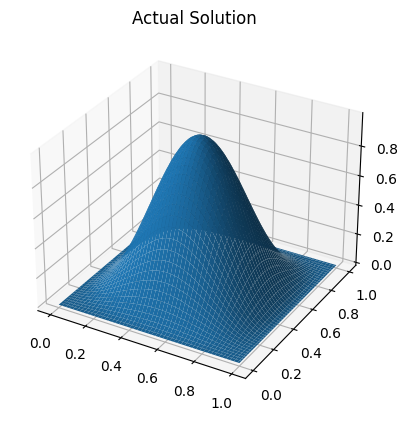

In [14]:
z = output.detach().numpy()
plot_graph(z,"Predicted Solution")
plot_graph(actual_soln(eps),"Actual Solution")

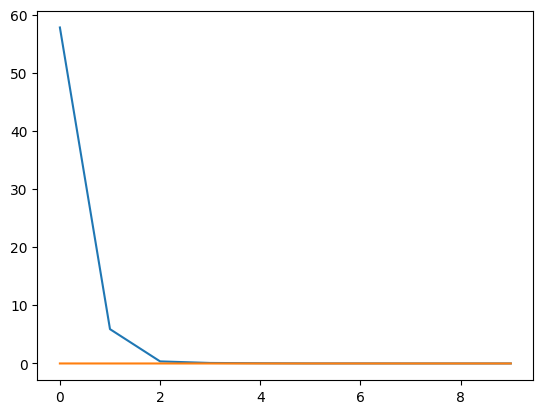

In [15]:
plt.plot(losses)
plt.show()